In [1]:
import gym
import math
import random
import tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from collections import deque
from itertools import count
from copy import deepcopy
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical

# создаем энвайронмент с игрой
env = gym.make('ALE/Breakout-v5').unwrapped

# настраиваем matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display    
print("Is python : {}".format(is_ipython))

# выбираем девайс для игры
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device : {}".format(device))

# запоминаем, сколько действий в игре
ACTIONS_NUM = env.action_space.n
print("Number of actions : {}".format(ACTIONS_NUM))

DeprecatedEnv: Env ALE/Breakout-v5 not found (valid versions include ['Breakout-v0', 'Breakout-v4'])

In [2]:
STATE_SIZE = 4
STATE_W = 84
STATE_H = 84
MEMSIZE = 200000

# Задание 1. Необходимо реализовать класс для хранения состояния игры. 
# В качестве последнего мы будем использовать состеканные 4 последовательных кадра игры.
# Это необходимо, чтобы агент понимал скорости и ускорения игровых объектов.
    
class StateHolder:
    
    def __init__(self, number_screens=4):
        self.first_action = True
        self.state = torch.ByteTensor(1, 84, 84).to(device)
        self.number_screens = number_screens
        
    def push(self, screen):
        new_screen = screen.squeeze(0)
        if self.first_action:
            self.state[0] = new_screen
            for number in range(self.number_screens-1):
                self.state = torch.cat((self.state, new_screen), 0)
            self.first_action = False
        else:
            self.state = torch.cat((self.state, new_screen), 0)[1:]
    
    def get(self):
        return self.state.unsqueeze(0)

    def reset(self):
        self.first_action = True
        self.state = torch.ByteTensor(1, 84, 84).to(device)
    
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))


class ReplayMemory:

    def __init__(self, capacity = MEMSIZE):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        #Положить переход в память
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        #Получить сэмпл из памяти
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
# Задание 2. Собрать архитектуру сети (DQN).
# В качестве примера можно использовать сеть вида:
# Conv(4->32) -> Conv(32->64) -> Conv(64->64) -> FC(512) -> FC(ACTIONS_NUM)
# В качестве функций активации необходимо использовать ReLU(но совершенно не обязательно ими ограничиваться)
# Attention : не забудьте правильно инициализировать веса, это важно для данной задачи!
class DuelingDQN(nn.Module):
    def __init__(self):
        super(DuelingDQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        nn.init.constant_(self.conv1.bias, 0)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        nn.init.constant_(self.conv2.bias, 0)
        
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        nn.init.kaiming_normal_(self.conv3.weight, nonlinearity='relu')
        nn.init.constant_(self.conv3.bias, 0)
        
        self.conv4 = nn.Conv2d(64, 1024, kernel_size=7, stride=1)
        nn.init.kaiming_normal_(self.conv4.weight, nonlinearity='relu')
        nn.init.constant_(self.conv4.bias, 0)
        # add comment
        self.fc_value = nn.Linear(512, 1)
        nn.init.kaiming_normal_(self.fc_value.weight, nonlinearity='relu')
        self.fc_advantage = nn.Linear(512, 4)
        nn.init.kaiming_normal_(self.fc_advantage.weight, nonlinearity='relu')
        
    def forward(self, x):
        x = x/255 
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        # add comment
        x_value = x[:,:512,:,:].view(-1,512)
        x_advantage = x[:,512:,:,:].view(-1,512)
        x_value = self.fc_value(x_value)
        x_advantage = self.fc_advantage(x_advantage)
        # add comment
        q_value = x_value + x_advantage.sub(torch.mean(x_advantage, 1)[:, None])
        return q_value

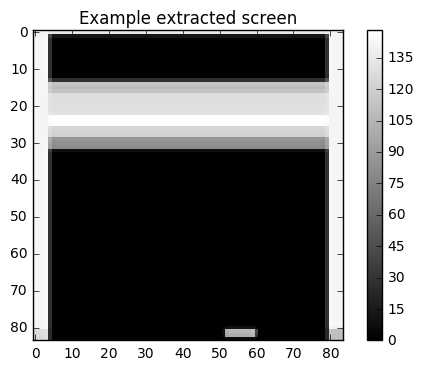

In [4]:
# Тут блок с кодом, генерирующим 1 кадр игры
# Обратите внимание, что выходным тензора является torch.ByteTensor со значениями 0-255
# Это сделанно намеренно для экономии места(4х экономия по сравнению с FloatTensor)
# Подумайте, где и как необходимо совершать преобразование ByteTensort -> FloatTensor, чтобы его можно было подавать в сеть. 

resize = T.Compose([T.ToPILImage(),
                    T.Resize( (STATE_W, STATE_H), interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_screen():
    screen = env.render(mode='rgb_array')
    screen = np.dot(screen[...,:3], [0.299, 0.587, 0.114])
    screen = screen[30:195,:]
    screen = np.ascontiguousarray(screen, dtype=np.uint8).reshape(screen.shape[0],screen.shape[1],1)
    return resize(screen).mul(255).type(torch.ByteTensor).to(device).detach().unsqueeze(0)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().reshape(-1,84).numpy(),
           interpolation='none', cmap = 'gray')
plt.title('Example extracted screen')
plt.colorbar()
plt.show()

In [5]:
# Далее стандартный метод для выбора нового действия из лекции

policy_net = DuelingDQN().to(device)
target_net = DuelingDQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)

def select_action(state, eps_threshold):
    global steps_done    
    sample = random.random()
    if sample > eps_threshold and state is not None:
        with torch.no_grad():
            return policy_net(state.float()).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(ACTIONS_NUM)]], device=device, dtype=torch.long)

mean_size = 100
mean_step = 1
train_rewards = []

In [6]:
def plot_rewards(rewards = train_rewards, name = "Train"):
    plt.figure(2)
    plt.clf()
    plt.title(name)
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(rewards)
    # Строим график среднего вознаграждения по 100 последним эпизодам
    if len(rewards) > mean_size:
        means = np.array([rewards[i:i+mean_size:] for i in range(0, len(rewards) - mean_size, mean_step)]).mean(1)
        means = np.concatenate((np.zeros(mean_size - 1), means))
        plt.plot(means)
    plt.show()

In [7]:
# Еще немного методов из лекции

BATCH_SIZE = 32
GAMMA = 0.99

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    # выбираем новый батч
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Для всех состояний считаем маску не финальнсти и конкантенируем их
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None]).float().to(device) 
    state_batch = torch.cat(batch.state).float().to(device)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Считаем Q(s_t, a) - модель дает Q(s_t), затем мы выбираем
    # колонки, которые соответствуют нашим действиям на щаге
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Подсчитываем ценность состяония V(s_{t+1}) для всех последующмх состояний.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_action = policy_net(non_final_next_states).detach().max(1)[1].view(-1,1)
    next_state_values[non_final_mask] = target_net(non_final_next_states).detach().gather(1, next_state_action).view(-1) # берем значение максимума
    
    # Считаем ожидаемое значение функции оценки ценности действия  Q-values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Считаем ошибку Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Оптимизация модели
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    del non_final_mask
    del next_state_action
    del non_final_next_states
    del state_batch
    del action_batch
    del reward_batch
    del state_action_values
    del next_state_values
    del expected_state_action_values
    del loss

In [8]:
# количество эпизодов, которые играем
NUM_EPISODES = 2000

# количество кадров, между которыми обучаем модель
OPTIMIZE_MODEL_STEP = 4
# количество кадров, между которыми обновляем target-модель
TARGET_UPDATE=10000

# несколько шагов для разогрева модели()
STEPS_BEFORE_TRAIN = 50000

# параметры для e-greedy стратегии выбора действия
EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 1000000 
eps_threshold = EPS_START

policy_net.train()
target_net.eval()

state_holder = StateHolder()
memory = ReplayMemory()
test_rewards = []
train_rewards = []

# Общее число 
steps_done = 0
optimizer = optim.Adam(policy_net.parameters(), lr=0.00001)

In [9]:
'''resume = True

if resume:
    checkpoint = torch.load('policy_net.tar')
    policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
    checkpoint = torch.load('target_net.tar')
    target_net.load_state_dict(checkpoint['target_net_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    checkpoint = torch.load('eps,steps,rew.tar')
    eps_threshold = checkpoint['eps']'''

"resume = True\n\nif resume:\n    checkpoint = torch.load('policy_net.tar')\n    policy_net.load_state_dict(checkpoint['policy_net_state_dict'])\n    checkpoint = torch.load('target_net.tar')\n    target_net.load_state_dict(checkpoint['target_net_state_dict'])\n    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])\n    checkpoint = torch.load('eps,steps,rew.tar')\n    eps_threshold = checkpoint['eps']"

In [10]:
# Задание 3. Заполнить пропуски в нижеприведенном коде.
#optimizer = optim.Adam(policy_net.parameters(), lr=0.000001)
NUM_EPISODES = 50000
for e in tqdm.tqdm_notebook(range(NUM_EPISODES)):
    env.reset()
    lives = 5
    ep_rewards = []
    state_holder.push(get_screen())
    
    for t in count():
        state = state_holder.get()
        # Рассчет eps_threshold'а для e-greedy
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
        action = select_action(state, eps_threshold)
        steps_done += 1
        
        # Шаг одного кадра игры 
        _, reward, done, info = env.step(action.item())
        life = info['ale.lives']
        ep_rewards.append(reward)
        reward = torch.tensor([reward], device=device)
        # где:
        # reward - награда, полученная в рамках последнего действия
        # done - флаг окончания эпизода
        # info - важная системная информация
        state_holder.push(get_screen())
        next_state = state_holder.get()
        # Код обработки перехода
        # Работа с ReplayMemory
        if not done:
            new_reward = reward
            next_state, lives = (None, life) if life < lives else (next_state, lives)
            memory.push(state.to('cpu'), action, next_state, new_reward)
            state = next_state
        else:
            next_state = None
            new_reward = torch.zeros_like(reward)
            memory.push(state.to('cpu'), action, next_state, new_reward)
            state = next_state
        
        # Задание 3.1. Необходимо дополниь код следующим трюком, который значительно
        # улучшает сходимость обучения. В случае, если эпизод не закончился, но агент на 
        # очередном шаге потерял жизнь, то такой переход надо класть в ReplayMemory как финальный.
        # При этом, необходимо далее продолжать эпизод игры, пока не получите done == True
        # Тет самым вы научите агента понимать, что терять жизни по дороге - плохо.
        
        # Шаг оптимизации
        if (steps_done > STEPS_BEFORE_TRAIN) and steps_done % OPTIMIZE_MODEL_STEP == 0:
            BATCH_SIZE = 32
            optimize_model()
        if e % 100 == 99 and  t == 0:
            print('\neps_threshold:', eps_threshold)
            print('steps_done: ', steps_done)
            # Средний reward по последним 100 эпизодам
            print("Mean score : {}".format(np.mean(train_rewards[-100:])))
        if e % 10 == 9 and  t == 0:
            print("10 ep.mean score : {}".format(np.mean(train_rewards[-10:])))
        if t > 18000:
            break
        # Шаг обновления target'сети
        if steps_done % TARGET_UPDATE == 0:
            print("Target net updated!")
            target_net.load_state_dict(policy_net.state_dict())
        
        # Код завершающий эпизод игры/обучения
        if done:
            train_rewards.append(np.sum(ep_rewards))
            break

10 ep.mean score : 0.8888888888888888
10 ep.mean score : 0.8
10 ep.mean score : 1.1
10 ep.mean score : 1.2
10 ep.mean score : 0.8
Target net updated!
10 ep.mean score : 1.4
10 ep.mean score : 1.2
10 ep.mean score : 1.6
10 ep.mean score : 0.6

eps_threshold: 0.9844117752815875
steps_done:  17473
Mean score : 1.0909090909090908
10 ep.mean score : 1.3
10 ep.mean score : 1.2
Target net updated!
10 ep.mean score : 1.2
10 ep.mean score : 1.6
10 ep.mean score : 1.2
10 ep.mean score : 0.7
10 ep.mean score : 0.5
10 ep.mean score : 0.5
Target net updated!
10 ep.mean score : 0.5
10 ep.mean score : 0.8

eps_threshold: 0.9693725663155472
steps_done:  34624
Mean score : 0.95
10 ep.mean score : 1.3
10 ep.mean score : 1.4
10 ep.mean score : 1.1
10 ep.mean score : 0.8
Target net updated!
10 ep.mean score : 1.6
10 ep.mean score : 0.6
10 ep.mean score : 0.7
10 ep.mean score : 1.2
10 ep.mean score : 1.1
Target net updated!
10 ep.mean score : 1.1

eps_threshold: 0.9541695952211876
steps_done:  52266
Mean s

KeyboardInterrupt: 

In [12]:
len(train_rewards)

13060

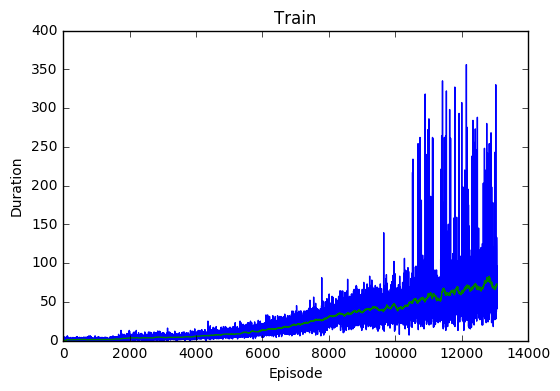

In [14]:
plot_rewards(train_rewards)

In [ ]:
# Задание 3. Заполнить пропуски в нижеприведенном коде.
optimizer = optim.Adam(policy_net.parameters(), lr=0.000001)
NUM_EPISODES = 10000
EPS_END = 0.02
for e in tqdm.tqdm_notebook(range(NUM_EPISODES)):
    env.reset()
    lives = 5
    ep_rewards = []
    state_holder.push(get_screen())
    
    for t in count():
        state = state_holder.get()
        # Рассчет eps_threshold'а для e-greedy
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
        action = select_action(state, eps_threshold)
        steps_done += 1
        
        # Шаг одного кадра игры 
        _, reward, done, info = env.step(action.item())
        life = info['ale.lives']
        ep_rewards.append(reward)
        reward = torch.tensor([reward], device=device)
        # где:
        # reward - награда, полученная в рамках последнего действия
        # done - флаг окончания эпизода
        # info - важная системная информация
        state_holder.push(get_screen())
        next_state = state_holder.get()
        # Код обработки перехода
        # Работа с ReplayMemory
        if not done:
            new_reward = reward
            next_state, lives = (None, life) if life < lives else (next_state, lives)
            memory.push(state.to('cpu'), action, next_state, new_reward)
            state = next_state
        else:
            next_state = None
            new_reward = torch.zeros_like(reward)
            memory.push(state.to('cpu'), action, next_state, new_reward)
            state = next_state
        
        # Задание 3.1. Необходимо дополниь код следующим трюком, который значительно
        # улучшает сходимость обучения. В случае, если эпизод не закончился, но агент на 
        # очередном шаге потерял жизнь, то такой переход надо класть в ReplayMemory как финальный.
        # При этом, необходимо далее продолжать эпизод игры, пока не получите done == True
        # Тет самым вы научите агента понимать, что терять жизни по дороге - плохо.
        
        # Шаг оптимизации
        if (steps_done > STEPS_BEFORE_TRAIN) and steps_done % OPTIMIZE_MODEL_STEP == 0:
            BATCH_SIZE = 32
            optimize_model()
        if e % 100 == 99 and  t == 0:
            print('\neps_threshold:', eps_threshold)
            print('steps_done: ', steps_done)
            # Средний reward по последним 100 эпизодам
            print("Mean score : {}".format(np.mean(train_rewards[-100:])))
        if e % 10 == 9 and  t == 0:
            print("10 ep.mean score : {}".format(np.mean(train_rewards[-10:])))
        if t > 18000:
            break
        # Шаг обновления target'сети
        if steps_done % TARGET_UPDATE == 0:
            print("Target net updated!")
            target_net.load_state_dict(policy_net.state_dict())
        
        # Код завершающий эпизод игры/обучения
        if done:
            train_rewards.append(np.sum(ep_rewards))
            break